In [79]:
import re
from datetime import datetime
import itertools

import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold
import japanize_matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

import wandb

In [80]:
class Config:
    exp_name = "e005_user_id_tar_enc"

In [81]:
train = pl.read_csv("../data/train.csv")
anime = pl.read_csv("../data/anime.csv")
test = pl.read_csv("../data/test.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# WandB

In [82]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin


True

In [83]:
wandb.init(
    project="atmacup15",
    name=Config.exp_name
)

# animeに対する前処理

### episodes

In [84]:
anime = anime.with_columns(
    pl.when(pl.col("episodes") == "Unknown")
    .then(None)
    .otherwise(pl.col("episodes"))
    .cast(pl.Int64)
    .alias("episodes")
)

### duration

In [85]:
def extract_duration_time(text: str) -> int | None:
    if match := re.match(r"([0-9]{1,2}) min.", text):
        return int(match.group(1))
    elif match := re.match(r"([1-9]{1}) hr. ([0-9]{1,2}) min.", text):
        
        return int(match.group(1)) * 60 + int(match.group(2))
    else:
        None

anime = anime.with_columns(
    pl.col("duration").apply(lambda x : extract_duration_time(x)).cast(pl.Int64).alias("duration_time")
)

duration_col = ["duration_time"]

### aired

In [86]:
def extract_aired_start_end(text: str) -> tuple[int | None, int | None, int | None, datetime | None, int | None, int | None, int | None, datetime | None]:
    months = "(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)"
    month_to_num = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    if match := re.match(f"({months}) ([0-9]{{1,2}}), ([0-9]{{4}}) to ({months}) ([0-9]{{1,2}}), ([0-9]{{4}})", text):
        start_year = int(match.group(4))
        start_month = match.group(2)
        start_month = month_to_num[start_month]
        start_day = int(match.group(3))
        start = datetime(start_year, start_month, start_day)

        end_year = int(match.group(8))
        end_month = match.group(6)
        end_month = month_to_num[end_month]
        end_day = int(match.group(7))
        end = datetime(end_year, end_month, end_day)

        return start_year, start_month, start_day, start, end_year, end_month, end_day, end
    
    elif match := re.match(f"({months}) ([0-9]{{1,2}}), ([0-9]{{4}})", text):
        start_year = int(match.group(4))
        start_month = match.group(2)
        start_month = month_to_num[start_month]
        start_day = int(match.group(3))
        start = datetime(start_year, start_month, start_day)
        return start_year, start_month, start_day, start, None, None, None, None
    
    else:
        return None, None, None, None, None, None, None, None

anime = anime.with_columns(
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[0]).alias("aired_start_year"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[1]).alias("aired_start_month"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[2]).alias("aired_start_date"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[3]).alias("aired_start"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[4]).alias("aired_end_year"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[5]).alias("aired_end_month"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[6]).alias("aired_end_date"),
    pl.col("aired").apply(lambda x : extract_aired_start_end(x)[7]).alias("aired_end"),
)

anime = anime.with_columns(
    pl.when(pl.col("aired_start").is_not_null() & pl.col("aired_end").is_not_null())
    .then((pl.col("aired_end") - pl.col("aired_start")))
    .otherwise(None)
    .apply(lambda x: x.days)
    .alias("aired_duration")
)

aired_col = ["aired_start_year", "aired_start_month", "aired_end_year", "aired_end_month", "aired_duration"]

### genres, producers, licensors, studios

In [87]:
# https://www.guruguru.science/competitions/21/discussions/7885664e-2acd-4191-833f-e1b21d34afc4/

multilabel_intput_cols = ["genres", "producers", "licensors", "studios"]
multilabel_dfs = []
multilabel_output_cols = []
for col in multilabel_intput_cols:
    out = anime.get_column(col).apply(lambda x: x.split(", "))
    mlb = MultiLabelBinarizer()
    ohe_srs = mlb.fit_transform(out)
    if col == "genres" or col == "licensors":
        # ユニーク数が多くないのでOne-hot表現のまま
        col_df = pl.DataFrame(ohe_srs)
        one_hot_col = [f"ohe_{col}_{name}" for name in mlb.classes_]
        col_df.columns = one_hot_col

        multilabel_output_cols += one_hot_col
    else:
        # ユニーク数が多いので、SVDで次元圧縮する
        n_components = 10
        svd = TruncatedSVD(n_components=n_components)
        svd_arr = svd.fit_transform(ohe_srs)
        col_df = pl.DataFrame(svd_arr)
        svd_cols = [f"svd_{col}_{ix}" for ix in range(n_components)]
        col_df.columns = svd_cols
        
        multilabel_output_cols += svd_cols
    multilabel_dfs.append(col_df)

multilabel_df = pl.concat(multilabel_dfs, how="horizontal")

In [88]:
anime = pl.concat([anime,multilabel_df], how="horizontal")

### 面白い指標、つまらない指標　members, watching, completed, on_hold, dropped

In [89]:
all_num_col = ["members", "watching", "completed", "on_hold", "dropped"]

int_trival_indicator_cols = []

for col_1, col_2 in list(itertools.permutations(all_num_col, 2)):
    col_name = f"{col_1}_div_{col_2}"
    int_trival_indicator_cols.append(col_name)
    anime = anime.with_columns(
        (pl.col(col_1) / pl.col(col_2)).alias(col_name)
    )

# Userがscoreを行った回数

In [90]:
user_id_cnt_df = pl.concat([train.select(["user_id", "anime_id"]), test]).get_column("user_id").value_counts()
user_id_cnt_dict = dict(zip(user_id_cnt_df.get_column("user_id"), user_id_cnt_df.get_column("counts")))

In [91]:
train = train.with_columns(
    pl.col("user_id").map_dict(user_id_cnt_dict).alias("user_scoring_cnt")
)

test = test.with_columns(
    pl.col("user_id").map_dict(user_id_cnt_dict).alias("user_scoring_cnt")
)

user_scoring_cnt_col = ["user_scoring_cnt"]

# Merge

In [92]:
train = train.join(anime, on="anime_id", how="left")
test = test.join(anime, on="anime_id", how="left")

# データ型の変更

In [93]:
categorical_cols = ["user_id", "anime_id", "type", "source", "rating"]

In [94]:
for col in categorical_cols:
    train = train.with_columns(
        pl.col(col).cast(pl.Categorical).alias(col)
    )
    test = test.with_columns(
        pl.col(col).cast(pl.Categorical).alias(col)
    )

# Seen Fold

In [95]:
FOLD_NUM = 5

In [96]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("user_id"))):
    empty[val_idx] = idx

train = train.with_columns(
    pl.Series(empty).cast(pl.Int64).alias("fold_seen")
)

/Users/shinichiro.saito/atmacup15/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# Unseen Fold

In [97]:
empty = np.zeros(train.height)
fold = GroupKFold(n_splits=FOLD_NUM)

for idx, (_, val_idx) in enumerate(fold.split(X=train, y=train.get_column("score"), groups=train.get_column("user_id"))):
    empty[val_idx] = idx

train = train.with_columns(
    pl.Series(empty).cast(pl.Int64).alias("fold_unseen")
)

In [98]:
# check
fold_0 = set(list(train.filter(
    pl.col("fold_unseen") == 0
).get_column("user_id").unique()))

fold_1 = set(list(train.filter(
    pl.col("fold_unseen") == 1
).get_column("user_id").unique()))

fold_0 & fold_1

set()

# Target Encoding

In [100]:
# TODO: yukiさんレビュー

valid_folds = []
for fold in range(FOLD_NUM):
    train_fold = train.filter(
        pl.col("fold_seen") != fold
    )

    tar_enc_df = train_fold.groupby("user_id").agg(
        pl.col("score").mean().alias("user_tar_enc_score_mean"),
        pl.col("score").std().alias("user_tar_enc_score_std"),
        pl.col("score").max().alias("user_tar_enc_score_max"),
        pl.col("score").min().alias("user_tar_enc_score_min")
    )

    valid_fold = train.filter(
        pl.col("fold_seen") == fold
    )

    valid_fold_with_tar_enc = valid_fold.join(tar_enc_df, on="user_id", how="left").select(
        ["user_id", "anime_id", "user_tar_enc_score_mean", "user_tar_enc_score_std", "user_tar_enc_score_max", "user_tar_enc_score_min"]
    )

    valid_folds.append(valid_fold_with_tar_enc)

user_id_anime_id_enc_df = pl.concat(valid_folds)

train = train.join(user_id_anime_id_enc_df, on=["user_id", "anime_id"])

tar_enc_col = ["user_tar_enc_score_mean", "user_tar_enc_score_std", "user_tar_enc_score_max", "user_tar_enc_score_min"]

# LightGBM

In [101]:
seen_use_col = []

base_col = [
    "episodes",
    "members",
    "watching",
    "completed",
    "on_hold",
    "dropped"
]

seen_use_col += base_col
seen_use_col += categorical_cols
seen_use_col += duration_col
seen_use_col += aired_col
seen_use_col += multilabel_output_cols
seen_use_col += int_trival_indicator_cols
seen_use_col += user_scoring_cnt_col
seen_use_col += tar_enc_col

len(seen_use_col)

153

In [102]:
unseen_use_col = []

base_col = [
    "episodes",
    "members",
    "watching",
    "completed",
    "on_hold",
    "dropped"
]

unseen_use_col += base_col
unseen_use_col += categorical_cols
unseen_use_col += duration_col
unseen_use_col += aired_col
unseen_use_col += multilabel_output_cols
unseen_use_col += int_trival_indicator_cols
unseen_use_col += user_scoring_cnt_col

unseen_use_col.remove("user_id")

len(seen_use_col)

153

In [103]:
def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

In [104]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "rmse",
    "metric": 'rmse',
    'max_depth': -1,
    'num_leaves': 24, #2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05, # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5, # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9, # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8, # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": 0, # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42, # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
}

In [107]:
def lgbm(train: pl.DataFrame, use_col: list, params: dict, fold_col: str):
    # 学習データ全体に対する推論結果を保存するobjectを作成
    oof = np.zeros((len(train)))

    # テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
    models = []

    # Cross Validationによる学習の実施
    for fold in range(FOLD_NUM):

        print(f"Start fold {fold}")
        
        # polarsをpandasに変換
        train_pd = train.to_pandas()

        # foldごとにtrainとvalidに分ける
        train_fold = train_pd[train_pd[fold_col] != fold] 
        valid_fold = train_pd[train_pd[fold_col] == fold]

        # X(説明変数)とy(目的変数)に分ける
        X_train = train_fold.drop("score", axis=1)
        X_valid = valid_fold.drop("score", axis=1)
        y_train = train_fold[["score"]]
        y_valid = valid_fold[["score"]]
        
        # 利用する説明変数に限定する
        X_train = X_train[use_col]
        X_valid = X_valid[use_col]
        
        # LightGBMが認識可能な形にデータセットを変換
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        
        # モデルの学習
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000, # 学習のiteration回数
            valid_sets=lgb_eval,
            callbacks=[lgb.early_stopping(stopping_rounds=100)] # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
        )
        
        # モデルを保存
        models.append(model)
        
        # validデータに対する推論
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
        
        # validデータに対する推論の性能を計算
        score = root_mean_squared_error(y_valid, y_valid_pred)
        print(f'fold {fold} RMSE: {score}')
        wandb.log({f"{fold_col} fold{fold}_rmse": score})

        # oofに推論結果を保存
        valid_idx = X_valid.index
        oof[valid_idx] = y_valid_pred
    return models, oof

### seen

In [108]:
seen_models, seen_oof = lgbm(train=train, use_col=seen_use_col, params=params, fold_col="fold_seen")

Start fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1903]	valid_0's rmse: 1.16666
fold 0 RMSE: 1.1666558227010155
Start fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignore

In [109]:
seen_oof_score = root_mean_squared_error(y_true=train.get_column("score"), y_pred=seen_oof)
wandb.log({f"seen_oof_rmse": seen_oof_score})

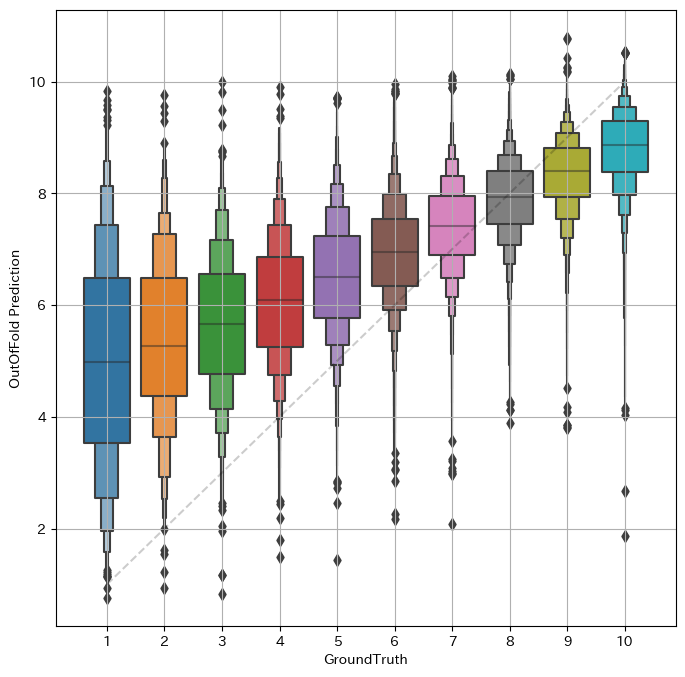

In [110]:
def pred_per_rate(train: pl.DataFrame, oof: np.array) -> None:

    fig, ax = plt.subplots(figsize=(8, 8))


    sns.boxenplot(data=pd.DataFrame({ "GroundTruth": np.array(train.get_column("score")), "OutOfFold Prediction": oof }), 
                x="GroundTruth", y="OutOfFold Prediction", ax=ax)

    ax.grid()
    ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

pred_per_rate(train, seen_oof)

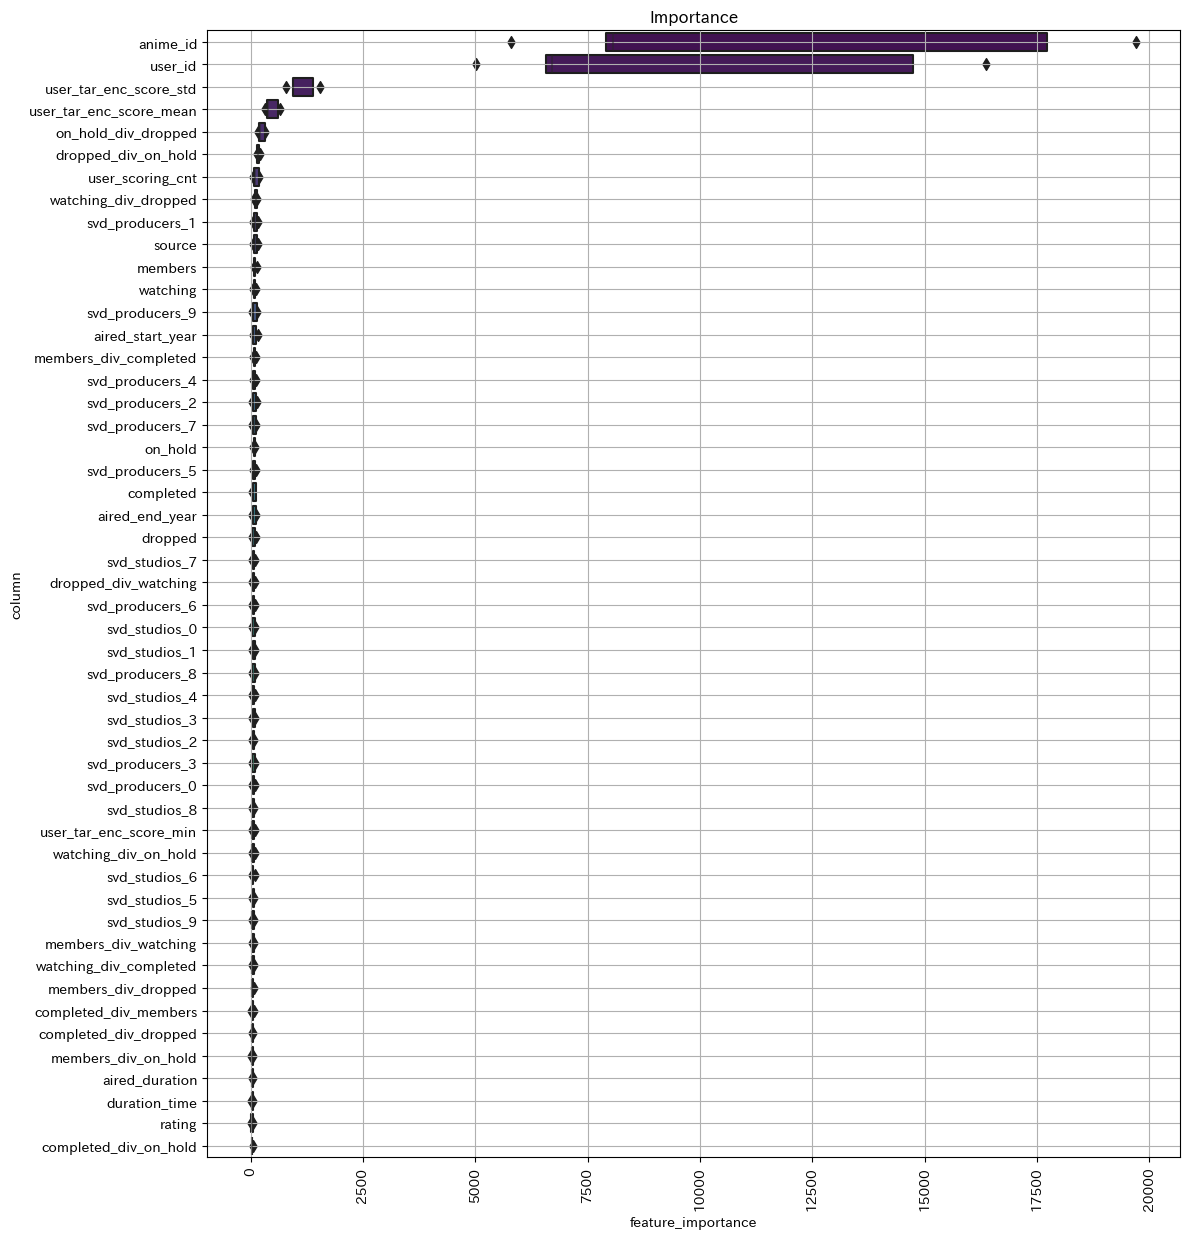

In [111]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(seen_models, seen_use_col)

In [112]:
print(len(seen_use_col))
print(len(unseen_use_col))

153
148


In [113]:
unseen_models, unseen_oof = lgbm(train=train, use_col=unseen_use_col, params=params, fold_col="fold_unseen")

Start fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 1.39223
fold 0 RMSE: 1.3922263795593215
Start fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored 

In [114]:
unseen_oof_score = root_mean_squared_error(y_true=train.get_column("score"), y_pred=unseen_oof)
wandb.log({f"unseen_oof_rmse": unseen_oof_score})

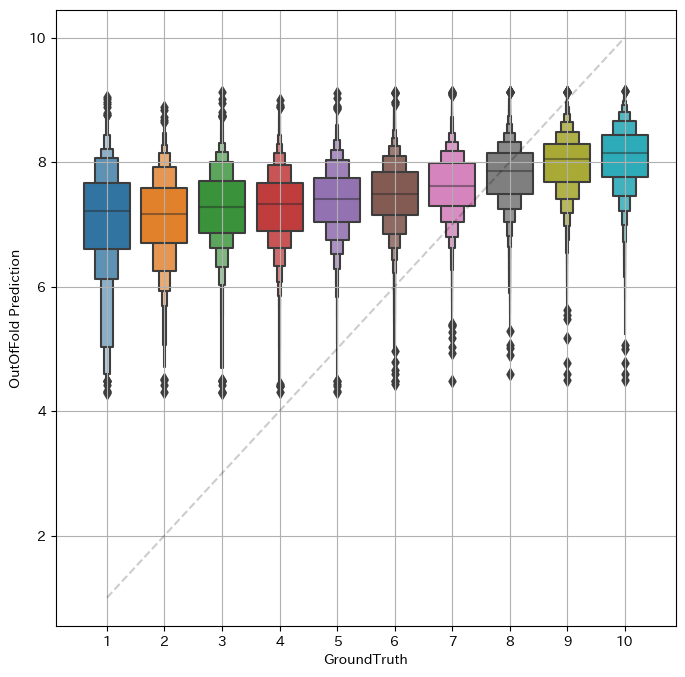

In [115]:
pred_per_rate(train, unseen_oof)

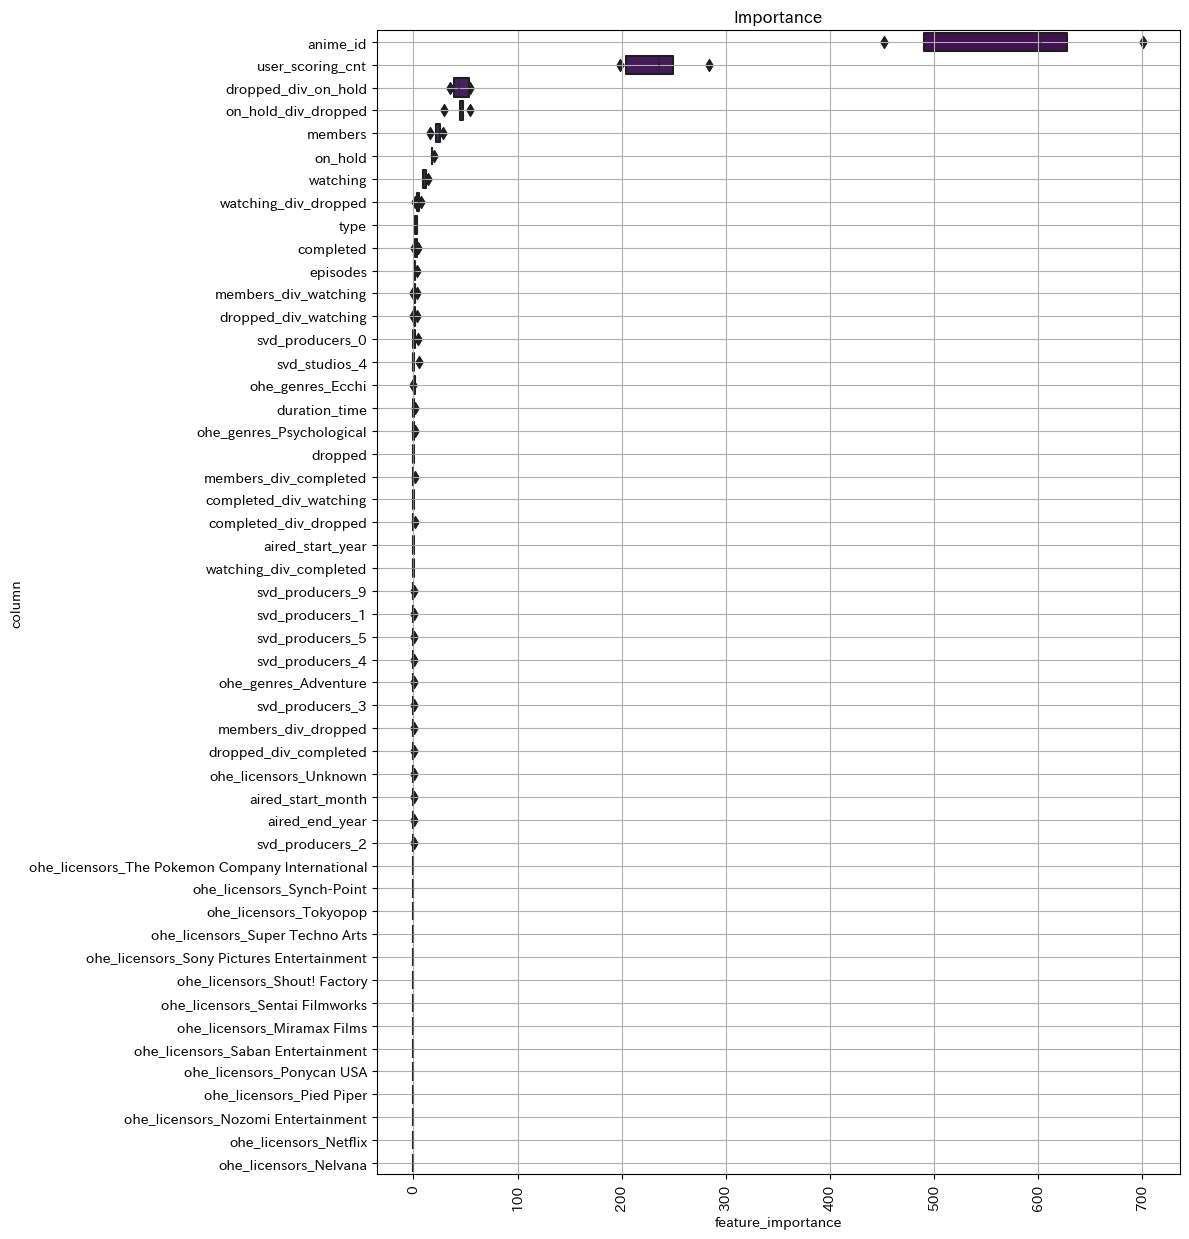

In [116]:
fig, ax = visualize_importance(unseen_models, unseen_use_col)

In [117]:
print(f"seen_oof_score: {seen_oof_score}")
print(f"unseen_oof_score: {unseen_oof_score}")

seen_oof_score: 1.1753146168660358
unseen_oof_score: 1.4329256308532


# Predict

In [118]:
seen_pred = np.array([model.predict(test.select(use_col).to_pandas()) for model in seen_models])
seen_pred = np.mean(seen_pred, axis=0)

unseen_pred = np.array([model.predict(test.select(unseen_use_col).to_pandas()) for model in unseen_models])
unseen_pred = np.mean(unseen_pred, axis=0)

NameError: name 'use_col' is not defined

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
# train_user_id_setに含まれる行についてはseen_pred, 含まれない行についてはunseen_predの推論結果を用いる

# trainに含まれるuser_idを取得
train_user_id_set = set(list(train.get_column("user_id").unique()))

# TODO: コンペ後、yukiさん、ヨハンさんにレビューをもらう
# 
test = test.with_columns(
    pl.Series(seen_pred).alias("seen_pred")
).with_columns(
    pl.Series(unseen_pred).alias("unseen_pred")
)

test = test.with_columns(
    pl.when(pl.col("user_id").cast(pl.Utf8).is_in(train_user_id_set))
    .then(pl.col("seen_pred"))
    .otherwise(pl.col("unseen_pred"))
    .alias("pred")
)

pred = np.array(test.get_column("pred"))

In [ ]:
def diff_test_oof(pred: np.array, oof: np.array):
    fig, ax = plt.subplots(figsize=(8, 6))

    vmax = .02
    bins = np.linspace(0, 10, 100)
    ax.hist(pred, bins=bins, density=True, alpha=.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    ax.set_title("テストとoofの予測傾向差分")

    fig.tight_layout()

In [ ]:
diff_test_oof(pred, seen_oof)

In [ ]:
diff_test_oof(pred, unseen_oof)

In [ ]:
pl.DataFrame({
    "score": pred
}).write_csv(f"../sub/{Config.exp_name}.csv")

In [ ]:
wandb.finish()